In [1]:
from csromer.simulation import FaradayThinSource,FaradayThickSource
from csromer.reconstruction import Parameter
import numpy as np
from IPython.display import clear_output
from csromer.io import Reader, Writer, filter_cubes
from csromer.base import Dataset
from csromer.transformers import DFT1D, NUFFT1D
import matplotlib.pyplot as plt
from csromer.objectivefunction import OFunction
from csromer.utils import real_to_complex, complex_to_real
from csromer.objectivefunction import TSV, TV, L1, Chi2
from csromer.optimization import FISTA, ADMM, SDMM, GradientBasedMethod
from csromer.utils import Gaussian
from csromer.dictionaries.discrete import DiscreteWavelet
from csromer.dictionaries.undecimated import UndecimatedWavelet
from csromer.transformers import Gridding, ManualFlagger, MeanFlagger, HampelFlagger
from csromer.faraday_sky import FaradaySky
from scipy.constants import c
from pynufft import NUFFT
from scipy import signal as sci_signal
import itertools
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as un
from astropy.stats import sigma_clipped_stats
import pandas as pd

In [2]:
# Read cubes
reader = Reader()
IQUV_name = "/home/miguel/Documents/datasets/A1314_JVLA/cubes/cubes.fits"
IQUV_header, IQUV = reader.readCube(file=IQUV_name)

FITS shape:  (4, 1024, 1024, 1024)


In [3]:
I, Q, U, nu = filter_cubes(IQUV[0], IQUV[1], IQUV[2], IQUV_header, [265, 323, 326, 328])

Filtering 33.69% of the total data


In [4]:
# Read spectral index
spc_idx_name = "/home/miguel/Documents/datasets/A1314_JVLA/cubes/alpha_0.fits"
hdul_alpha = fits.open(spc_idx_name, memmap=True)

In [5]:
# Get LOS

#coord = SkyCoord(ra=173.498*un.deg, dec=49.063*un.deg, frame="fk5") # IC708
#coord = SkyCoord(ra=173.705*un.deg, dec=49.078*un.deg, frame="fk5") # IC712
#coord = SkyCoord(ra=173.694*un.deg, dec=48.957*un.deg, frame="fk5") # IC711
#coord = SkyCoord(ra=173.675*un.deg, dec=48.973*un.deg, frame="fk5") # IC711 tail peak
#coord = SkyCoord(ra=173.470*un.deg, dec=49.075*un.deg, frame="fk5") # IC708 North Lobe peak
#coord = SkyCoord(ra=173.470*un.deg, dec=49.057*un.deg, frame="fk5") # IC708 South Lobe peak
#coord = SkyCoord(ra=173.803*un.deg, dec=48.967*un.deg, frame="fk5")# Source 13
coord = SkyCoord(ra=173.453*un.deg, dec=48.985*un.deg, frame="fk5")# Source 1

In [6]:
# Get WCS
wcs = WCS(IQUV_header)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [7]:
# Get pixel
x,y = coord.to_pixel(wcs, origin=0)
x = int(x)
y = int(y)

In [8]:
q_data = np.flipud(Q)
u_data = np.flipud(U)

In [9]:
# Get sigma
mean_q, median_q, std_q = sigma_clipped_stats(q_data[:, 0:500, 0:500], sigma=5, axis=(1,2))
mean_u, median_u, std_u = sigma_clipped_stats(u_data[:, 0:500, 0:500], sigma=5, axis=(1,2))
#std_q = np.nanstd(q_data[:, 0:500, 0:500], axis=(1, 2))
#std_u = np.nanstd(u_data[:, 0:500, 0:500], axis=(1, 2))

In [10]:
mean_qu = 0.5*(mean_q + mean_u)
sigma_qu = 0.5*(std_q + std_u)
#sigma_qu = np.ones_like(q_data[:,0,0])

In [11]:
data = q_data[:,y,x] + 1j * u_data[:,y,x]
alpha = hdul_alpha[0].data[y,x]

In [12]:
alpha

-0.50288004

In [13]:
measurements = Dataset(nu=nu, data=data, sigma=sigma_qu, spectral_idx=alpha)

In [14]:
# Get galactic RM contribution
f_sky = FaradaySky()
gal_mean, gal_std = f_sky.galactic_rm(coord.ra, coord.dec, frame="fk5")

In [15]:
measurements.subtract_galacticrm(gal_mean.value)

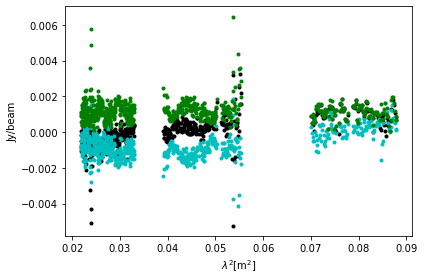

In [16]:
plt.plot(measurements.lambda2, measurements.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
#plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

In [17]:
mean_sigma = np.mean(measurements.sigma)
stderr_sigma = np.std(measurements.sigma) / np.sqrt(len(measurements.sigma))
print(mean_sigma)
print(stderr_sigma)
print(mean_sigma + 5*stderr_sigma)

0.0004612613921845483
1.0219223078494682e-05
0.0005123575075770217


Text(0, 0.5, '1/(Jy/beam)$^2$')

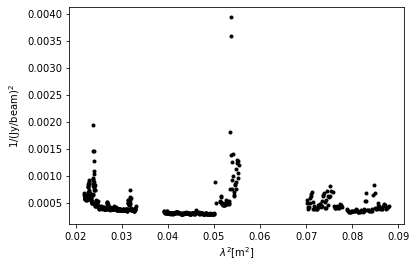

In [18]:
plt.plot(measurements.lambda2, measurements.sigma, 'k.', label=r"$\sigma$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'1/(Jy/beam)$^2$')

In [19]:
## Flagging dataset ##
normal_flagger = MeanFlagger(data=measurements, nsigma=5.0, delete_channels=True)
idxs, outliers_idxs = normal_flagger.run()
#hampel_flagger = HampelFlagger(data=measurements, nsigma=5.0, delete_channels=True)
#idxs, outliers_idxs = hampel_flagger.run()

Flagging 22.53% of the data


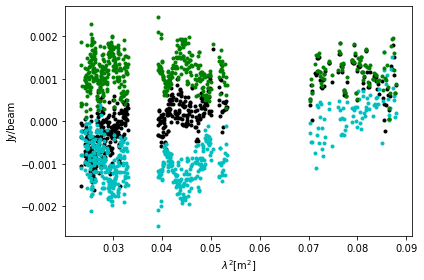

In [20]:
plt.plot(measurements.lambda2, measurements.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
#plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

In [21]:
# measurements.sigma = np.ones_like(measurements.sigma)

Text(0, 0.5, 'Jy/beam')

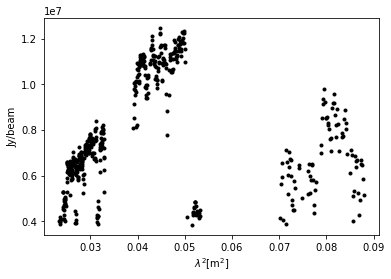

In [22]:
plt.plot(measurements.lambda2, measurements.w, 'k.', label=r"$\sigma$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')

In [23]:
parameter = Parameter()

In [24]:
parameter.calculate_cellsize(dataset=measurements, oversampling=8)

FWHM of the main peak of the RMTF: 53.698 rad/m^2
Maximum recovered width structure: 134.146 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 14095.644


In [25]:
nufft = NUFFT1D(dataset=measurements, parameter=parameter, solve=True)

In [26]:
dft = DFT1D(dataset=measurements, parameter=parameter)

In [27]:
F_dirty = dft.backward(measurements.data)

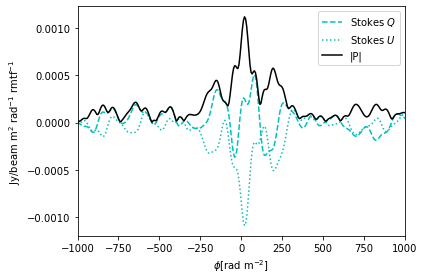

In [28]:
plt.plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_dirty), 'k-', label=r"|P|")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000,1000])
plt.tight_layout()
#plt.savefig('fdirty.png', dpi=100, bbox_inches='tight')

In [29]:
parameter.phi[np.argmax(np.abs(F_dirty))]

20.175062920139766

In [30]:
noise = 0.5 * (np.std(F_dirty.real[np.abs(parameter.phi)>parameter.max_faraday_depth/2]) + np.std(F_dirty.imag[np.abs(parameter.phi)>parameter.max_faraday_depth/2]))
#noise = 1/np.sqrt(np.sum(measurements.w))
noise * 1000.0

0.018867758626583964

In [31]:
noise_weights = 1.0/np.sqrt(np.sum(measurements.w))
noise_weights * 1000.0

0.015624854878783581

In [32]:
wav = None
#wav = UndecimatedWavelet(wavelet_name="coif2")

In [33]:
lambda_l1 = np.sqrt(2 * len(measurements.data) + np.sqrt(4 * len(measurements.data))) * noise/2
#lambda_l1 = np.sqrt(len(measurements.data)) * noise_F
#lambda_l1 /= 4
#lambda_tsv = 0.0
chi2 = Chi2(dft_obj=nufft, wavelet=wav)
l1 = L1(reg=lambda_l1)
#tsv = TSV(reg=lambda_tsv)
# F_func = [chi2(P, dft, W), L1(lambda_l1)]
F_func = [chi2, l1]
f_func = [chi2]
g_func = [l1]

F_obj = OFunction(F_func)
f_obj = OFunction(f_func)
g_obj = OFunction(g_func)

In [34]:
parameter.data = F_dirty
parameter.complex_data_to_real()
if wav is not None:
    wav.calculate_max_level(parameter.data)
    parameter.data = wav.decompose(parameter.data)

In [35]:
parameter.n

8384

In [36]:
nufft.parameter.n

4192

In [37]:
opt = FISTA(guess_param=parameter, F_obj=F_obj, fx=chi2, gx=g_obj, noise=noise, verbose=True)
#opt = FISTA(i_guess=F_real, F_obj=F_obj, fx=chi2, gx=g_obj, maxiter=1000, noise=1e-5, verbose=True)
obj, X = opt.run()

Iterations set to 16
Iteration:  0  objective function value: 2229.83431


In [38]:
if wav is not None:
    plt.plot(X.data)

In [39]:
if wav is not None:
    X.data = wav.reconstruct(X.data)
X.real_data_to_complex()

(-1000.0, 1000.0)

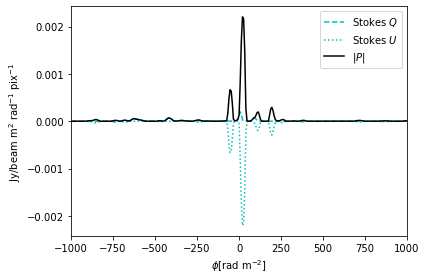

In [40]:
plt.plot(parameter.phi, X.data.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, X.data.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(X.data), 'k-', label=r"$|P|$")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim([-1000,1000])

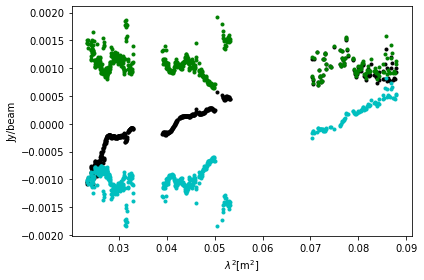

In [41]:
plt.plot(measurements.lambda2, measurements.model_data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.model_data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.model_data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
#plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

In [42]:
fitted = measurements.w * measurements.model_data / measurements.s

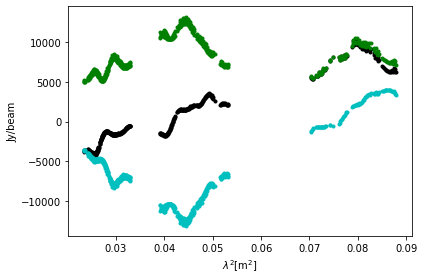

In [43]:
plt.plot(measurements.lambda2, fitted.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, fitted.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(fitted), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
#plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

(-1000.0, 1000.0)

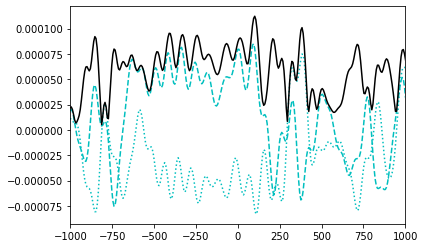

In [44]:
F_residual = dft.backward(measurements.residual)
plt.plot(parameter.phi, F_residual.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_residual.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_residual), 'k-', label=r"$|P|$")
plt.xlim([-1000,1000])

In [45]:
conv_model = X.convolve(normalized=True) + F_residual

In [46]:
noise_residual = 0.5 * (np.std(F_residual.real) + np.std(F_residual.imag))
noise_residual

2.3459057047148235e-05

In [47]:
noise = 0.5*(np.std(F_dirty.real[np.abs(parameter.phi)>parameter.max_faraday_depth/2]) + np.std(F_dirty.imag[np.abs(parameter.phi)>parameter.max_faraday_depth/2]))
noise

1.8867758626583964e-05

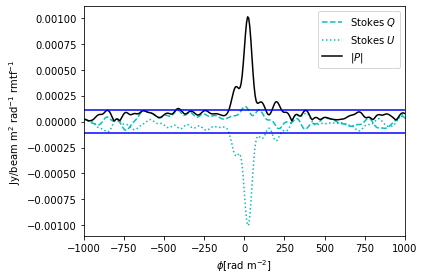

In [48]:
plt.plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(conv_model), 'k-', label=r"$|P|$")
plt.xlim([-1000,1000])
plt.axhline (y = 6*noise, color = 'b')
plt.axhline (y = -6*noise, color = 'b')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()

In [49]:
phi_idx = np.argmax(np.abs(conv_model))
parameter.phi[phi_idx]

20.175062920139766

In [50]:
np.argmax(conv_model.real), np.argmax(conv_model.imag)

(2097, 2250)

In [51]:
np.max(np.abs(conv_model))

0.0010103759770353174

In [52]:
noise * 1000.0

0.018867758626583964

In [53]:
noise/np.max(np.abs(conv_model))

0.018673997655750327